# NEED Question :
#### Part 1: Is there a seasonal variation in the ratings of businesses?

####  Part 2: Comparing reviews to the average for that business, do users rate businesses higher or lower than the average in certain months?

#### Part 3: Does this vary geographically or by category?

# Table of Contents
#### Section 1: Question Interpretation 
#### Section 2: Hypothesis
#### Section 3: Data Files Imports
#### Section 4: Selecting catergory
#### Section 5: Defining Seasons
#### Section 6: Results
#### Section 7: Limitations

## Section 1: Question Interpretation:
We interpret the questions as do people in the varying seasons rate a business differently because the season affects the person's mood at the time of the rating? The 2nd part of the question can be intpreted as do business get rated higher then their average in the varying months? Is this because the severity of each season in the varying months affects how a person rates a business. The 3rd part of the question is interpreted as do the seasonal changes vary more by category, as in do people rate a restaurants higher or lower then average in the summer then in the winter because the warmth elevates a persons mood?, or does it vary more by geography, as in does the severity of the seasons in each state affect how positive or negative a person reviews a business.


# Section 2: Hypothesis
We believe that there is a variation in how a person affects a business. We think it is because most people are influenced by the season in their state and that mood is either positive or negative because of how hot or cold it can be. By seeing if a greater difference between the stars and average stars exists using the categories and geophraphy we can determine if season is a determining factor in the rating of a business. 

# Section 3: Data Imports
The following 3 cells brings in the review data and business data to test our hypothesis. From the review data we will use the date of the reivews to determine what a season is in each state. We will also use the business data to get the geographic location of each review and business. Combining these 2 tables with that information will allow us to start making our comparisions.

In [1]:
# The code was removed by DSX for sharing.

In [2]:
path_reviews = cos.url('review.json.bz2', 'spring2018hui0fad905366d545279723d76bbe9b5cdd')
df_reviews = spark.read.json(path_reviews)
print "Number of reviews: ",df_reviews.count()
df_reviews.createOrReplaceTempView("yelp_reviews")

df_reviews.printSchema()




Number of reviews:  5261669
root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [3]:
path_business = cos.url('business.json.bz2', 'spring2018hui0fad905366d545279723d76bbe9b5cdd')
df_business = spark.read.json(path_business)
print "business count:", df_business.count()
df_business.printSchema()
df_business.show(truncate = False)

df_business.createOrReplaceTempView("yelp_business")

business count: 174567
root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: boolean (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: struct (nullable = true)
 |    |    |-- casual: boolean (nullable = true)
 |    |    |-- classy: boolean (nullable = true)
 |    |    |-- divey: boolean (nullable = true)
 |    |    |-- hipster: boolean (nullable = true)
 |    |    |-- intimate: boolean (nullable = true)
 |    |    |-- romantic: boolean (nullable = true)
 |    |    |-- touristy: boolean (nullable = true)
 |    |    |-- trendy: boolean (nullable = true)
 |    |    |-- upscale: boolean (nullable = true)
 |    |-- BYOB: boolean (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: struct (nullable = true)
 |    |    |-- friday: boolean (nullable = true)
 |    |    |-- monday: boolean (nullable = true)
 |    |    |-- sa

# Section 4: Structuring, Enriching, Cleaning Data
From the business data, we grab the categories to flatten our data structure. According to the Yelp's 10K report, we found that Restaurants, Shopping, and Nightlife businesses are the three categories that contain the most amount of reviews. Hence, We chose these three categories. They are not only fairly broad but also will reduce redundant data keeping it bias-free. We also include shopping centers into our Shopping category to further reduce redundancy.

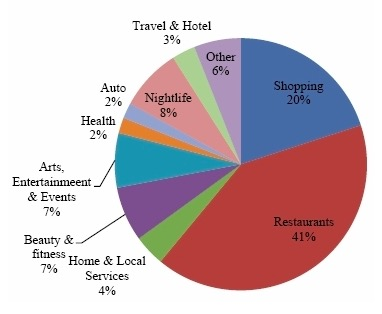

In [4]:
df_categories = spark.sql("""SELECT business_id, categories
FROM yelp_business
WHERE array_contains(categories,'Restaurants') OR array_contains(categories,'Shopping') 
OR array_contains(categories,'Nightlife') OR array_contains(categories, 'Shopping Centers')""")

print "Number of restaurants, shopping, nightlife businesses: ", df_categories.count()
df_categories.show(5, truncate=False)

df_categories.createOrReplaceTempView("select_categories")

Number of restaurants, shopping, nightlife businesses:  86654
+----------------------+-------------------------------------------------------------------------------------------+
|business_id           |categories                                                                                 |
+----------------------+-------------------------------------------------------------------------------------------+
|8DShNS-LuFqpEWIp0HxijA|[Sporting Goods, Shopping]                                                                 |
|PfOCPjBrlQAnz__NXj9h_w|[American (New), Nightlife, Bars, Sandwiches, American (Traditional), Burgers, Restaurants]|
|o9eMRCWt5PkpLDE0gOPtcQ|[Italian, Restaurants]                                                                     |
|OD2hnuuTJI9uotcKycxg1A|[Shopping, Sporting Goods]                                                                 |
|XOSRcvtaKc_Q5H1SAzN20A|[Breakfast & Brunch, Gluten-Free, Coffee & Tea, Food, Restaurants, Sandwiches]             |
+-

# Section 4 Continued:
This table combines our current queried results into one table for ease of access and readability. We currently combined our business_id, date, stars and review_id from the reviews table with our states and review count from the business table. The business ID is the primary key we will use to combine our data. The result is shown below with our businesses with their corresponding states and categories. 

In [5]:
df_main_table = spark.sql("""
SELECT R.business_id, R.date, R.stars, R.review_id, B.state, B.review_count, C.categories
FROM yelp_reviews AS R, yelp_business AS B , select_categories AS C
WHERE B.business_id = R.business_id AND B.business_id = C.business_id
""")

df_main_table.createOrReplaceTempView("working_table")
df_main_table.show(5,truncate=False)



+----------------------+----------+-----+----------------------+-----+------------+----------------------------------------------------------------------------------+
|business_id           |date      |stars|review_id             |state|review_count|categories                                                                        |
+----------------------+----------+-----+----------------------+-----+------------+----------------------------------------------------------------------------------+
|0W4lkclzZThpx3V65bVgig|2016-05-28|5    |v0i_UHJMo_hPBq9bxWvW4w|QC   |1953        |[Specialty Food, Sandwiches, Restaurants, Imported Food, Ethnic Food, Delis, Food]|
|AEx2SYEUJmTxVVB18LlCwA|2016-05-28|5    |vkVSCC7xljjrAI4UGfnKEQ|QC   |84          |[Diners, Food, Restaurants, Delis]                                                |
|VR6GpWIda3SfvPC-lg9H3w|2016-05-28|5    |n6QzIUObkYshz4dz2QRJTw|QC   |50          |[Restaurants, Canadian (New), Italian]                                            

# Section 4 Continued:
With our combined table we must figure out the average review for each business. We do this by using the AVG() function in SQL to average the ratings for each business. 

In [6]:
df_avg_star=spark.sql("""
SELECT  business_id, AVG(stars) AS AVG
FROM yelp_reviews
GROUP BY business_id
""")

df_avg_star.createOrReplaceTempView("AVG_star")
df_avg_star.show()

+--------------------+------------------+
|         business_id|               AVG|
+--------------------+------------------+
|RtUvSWO_UZ8V3Wpj0...| 4.112331081081081|
|jXjglUcr2bDKdoV4l...|               3.7|
|N3J76CRP2H52NUo4V...| 4.205479452054795|
|jOqh0eVjqtUOpZ9AZ...| 4.357142857142857|
|BMAflH82OUIMl2mHt...| 3.463768115942029|
|_ixV2SWDy7w8jzEAH...| 3.649025069637883|
|j0_CApMCHDJBYJg1X...| 4.097345132743363|
|CAmPPSKoFCd8zo2bx...| 3.710526315789474|
|YjPWt-V5oMkakdRWr...|4.0476190476190474|
|JsUytp_MuZ4AX5JWf...| 3.466666666666667|
|JFhfVTt_8xNjtwqSD...|3.1052631578947367|
|X26lmoKvv_KvW6WcA...|3.5454545454545454|
|MgSd4P3ATkiywbbra...| 3.994949494949495|
|JLbgvGM4FXh9zNP4O...| 4.113067027758971|
|1NmGVWYlF4iMngM6a...|3.7529411764705882|
|cz5vz-893D3LNH3TM...| 3.769230769230769|
|gogO5RF4Rqz2THF1A...|3.5209876543209875|
|b-dMCUh7T2Kya1O7Z...| 2.727272727272727|
|cdkzUI1tXc8rUMF33...|3.0985915492957745|
|Nf-Y0Ozjtff417vPS...| 3.090909090909091|
+--------------------+------------

# Section 4 Continued: 
 Once the average review rating is created we combine that with our table called working_table to start our comparison.  We also include a difference column that shows the difference between the rating of the particular business and the average rating in that category. For example, if the difference is 0, it means that the rating of the business is equal to the average rating; if the difference is 1, it means the rating of the business is higher than the average rating and the difference is 1; If the difference is -1, means the rating of the business is lower than the average rating, and the difference is 1. We can use this to determine how to view the place of that business in that category. 
To answer our other questions we create a case statement that combines North Carolina with South Carolina because they are representing the same metropolitan area of Charlotte.

In [7]:
df_final_table=spark.sql("""
SELECT W.business_id,W.stars, A.AVG, (W.stars-A.AVG) AS Difference,W.date,W.categories,W.state,W.review_count,
CASE
        WHEN state = "SC" THEN "NC"
        ELSE
          state
    END AS updated_states
FROM working_table AS W, AVG_star AS A
WHERE W.business_id = A.business_id""")

df_final_table.createOrReplaceTempView("final_table")
df_final_table.show(20, truncate=False)


+----------------------+-----+-----------------+--------------------+----------+----------------------------------------+-----+------------+--------------+
|business_id           |stars|AVG              |Difference          |date      |categories                              |state|review_count|updated_states|
+----------------------+-----+-----------------+--------------------+----------+----------------------------------------+-----+------------+--------------+
|--9e1ONYQuAa-CB_Rrw7Tw|5    |4.088904203997243|0.9110957960027566  |2011-08-24|[Cajun/Creole, Steakhouses, Restaurants]|NV   |1451        |NV            |
|--9e1ONYQuAa-CB_Rrw7Tw|5    |4.088904203997243|0.9110957960027566  |2016-03-31|[Cajun/Creole, Steakhouses, Restaurants]|NV   |1451        |NV            |
|--9e1ONYQuAa-CB_Rrw7Tw|4    |4.088904203997243|-0.08890420399724341|2015-06-29|[Cajun/Creole, Steakhouses, Restaurants]|NV   |1451        |NV            |
|--9e1ONYQuAa-CB_Rrw7Tw|5    |4.088904203997243|0.91109579600275

# Section 4 Continued:
The final piece of enrichment we must do is Explode our categories so we can write out the table to a tsv file. The other part of our enrichment involves creating a case statement to define what seasons occur month to month on a geographical basis.

In [8]:
df_rank=spark.sql("""
SELECT ROW_NUMBER() OVER (ORDER BY review_count) as Row_number, business_id, AVG, Difference, date, EXPLODE(categories) as category, updated_states ,review_count,
    CASE 
    WHEN updated_states = 'PA' AND month(date) in (12, 1, 2, 3) THEN 'winter'
    WHEN updated_states = 'PA' AND month(date) in (4, 5) THEN 'spring'
    WHEN updated_states = 'PA' AND month(date) in (6, 7, 8, 9) THEN 'summer'
    WHEN updated_states = 'PA' AND month(date) in (10, 11) THEN 'fall'
    
    WHEN updated_states = 'QC' AND month(date) in (12, 1, 2) THEN 'winter'
    WHEN updated_states = 'QC' AND month(date) in (3, 4, 5) THEN 'spring'
    WHEN updated_states = 'QC' AND month(date) in (6, 7, 8) THEN 'summer'
    WHEN updated_states = 'QC' AND month(date) in (9, 10, 11) THEN 'fall'
    
    WHEN updated_states = 'ON' AND month(date) in (12, 1, 2) THEN 'winter'
    WHEN updated_states = 'ON' AND month(date) in (3, 4, 5) THEN 'spring'
    WHEN updated_states = 'ON' AND month(date) in (6, 7, 8) THEN 'summer'
    WHEN updated_states = 'ON' AND month(date) in (9, 10, 11) THEN 'fall'
    
    WHEN updated_states = 'WI' AND month(date) in (12, 1, 2, 3) THEN 'winter'
    WHEN updated_states = 'WI' AND month(date) in (4, 5) THEN 'spring'
    WHEN updated_states = 'WI' AND month(date) in (6, 7, 8, 9) THEN 'summer'
    WHEN updated_states = 'WI' AND month(date) in (10, 11) THEN 'fall'
    
    WHEN updated_states = 'AZ' AND month(date) in (12, 1) THEN 'winter'
    WHEN updated_states = 'AZ' AND month(date) in (2, 3) THEN 'spring'
    WHEN updated_states = 'AZ' AND month(date) in (4, 5, 6, 7, 8, 9) THEN 'summer'
    WHEN updated_states = 'AZ' AND month(date) in (10, 11) THEN 'fall'
    
    WHEN updated_states = 'IL' AND month(date) in (12, 1, 2, 3) THEN 'winter'
    WHEN updated_states = 'IL' AND month(date) in (4, 5) THEN 'spring'
    WHEN updated_states = 'IL' AND month(date) in (6, 7, 8, 9) THEN 'summer'
    WHEN updated_states = 'IL' AND month(date) in (10, 11) THEN 'fall'
    
    WHEN updated_states = 'NV' AND month(date) in (12, 1, 2, 3) THEN 'winter'
    WHEN updated_states = 'NV' AND month(date) in (4, 5) THEN 'spring'
    WHEN updated_states = 'NV' AND month(date) in (6, 7, 8, 9) THEN 'summer'
    WHEN updated_states = 'NV' AND month(date) in (10, 11) THEN 'fall'
    
    WHEN updated_states = 'OH' AND month(date) in (12, 1, 2) THEN 'winter'
    WHEN updated_states = 'OH' AND month(date) in (3, 4, 5) THEN 'spring'
    WHEN updated_states = 'OH' AND month(date) in (6, 7, 8) THEN 'summer'
    WHEN updated_states = 'OH' AND month(date) in (9, 10, 11) THEN 'fall'
    
    WHEN updated_states = 'NC' AND month(date) in (12, 1, 2) THEN 'winter'
    WHEN updated_states = 'NC' AND month(date) in (3, 4, 5) THEN 'spring'
    WHEN updated_states = 'NC' AND month(date) in (6, 7, 8, 9) THEN 'summer'
    WHEN updated_states = 'NC' AND month(date) in (10, 11) THEN 'fall'
    END AS season
FROM final_table
ORDER BY review_count DESC
""")

df_rank.show(100,truncate=False)


+----------+----------------------+-----------------+-------------------+----------+------------------+--------------+------------+------+
|Row_number|business_id           |AVG              |Difference         |date      |category          |updated_states|review_count|season|
+----------+----------------------+-----------------+-------------------+----------+------------------+--------------+------------+------+
|17304087  |4JNXUYY8wbaaDmk3BPzlWw|4.120483564248845|-0.1204835642488451|2017-10-25|French            |NV            |7361        |fall  |
|17304187  |4JNXUYY8wbaaDmk3BPzlWw|4.120483564248845|-0.1204835642488451|2014-12-03|French            |NV            |7361        |winter|
|17304088  |4JNXUYY8wbaaDmk3BPzlWw|4.120483564248845|-0.1204835642488451|2017-10-25|Steakhouses       |NV            |7361        |fall  |
|17304089  |4JNXUYY8wbaaDmk3BPzlWw|4.120483564248845|-0.1204835642488451|2017-10-25|Restaurants       |NV            |7361        |fall  |
|17304090  |4JNXUYY8wbaaDmk

# Section 5 Defining Seasons
The following list defines what seasons occur in each state on a month to month basis. We use this information because one state may be considered in one season in one month while another state is going through another season in the same month. For instance, Arizona may be facing summer like conditions in April while Illinois faces Spring like conditions in April. The following defintions come from US climate data and Canada's climate site. The following image visually displays what season each of the 9 states go through on a yearly basis.

data source 
https://www.usclimatedata.com/ <br>
https://weather-and-climate.com/average-monthly-Rainfall-Temperature-Sunshine-in-Canada




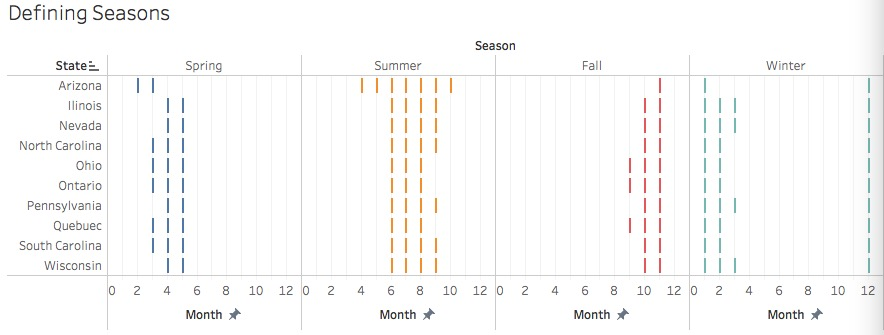

# Below are the detailed explanation of the above picture.
### North Carolina/South Carolina: <br>
December, Janurary, February = Winter<br>
March, April, May = Spring<br>
June, July, August, September = Summer<br>
October, November = Fall<br>
### Pennsylvania <br>
December, January, Febuary, March = Winter <br>
April, May = spring <br>
June, July, August, September = Summer <br>
October, November = Fall <br>
### Quebuec <br>
December, January, Febuary = Winter <br>
March, April, May = Spring <br>
June, July, August = Summer <br>
September, October, November = Fall <br>
### Ontario <br>
December, January, Febuary = Winter <br>
March, April, May = Spring <br>
June, July, August = Summer <br>
September, October, November = Fall <br>
### Wisconsin <br>
December, January, Feburary, March = Winter <br>
April, May = Spring <br>
June, July, August, September = Summer <br> 
October, November = Fall<br>
### Arizona <br>
December, January = Winter <br>
Febuary, March = Spring <br>
April, May, June, July, September, October = Summer <br>
November = Fall <br>
### Ilinois <br>
December, January, Feburary, March = Winter <br>
April, May = Spring <br>
June, July, August, September = Summer <br> 
October, November = Fall<br>
### Nevada <br>
December, January, Feburary, March = Winter <br>
April, May = Spring <br>
June, July, August, September = Summer <br> 
October, November = Fall<br>
### Ohio <br>
December, January, Febuary = Winter <br>
March, April, May = Spring <br>
June, July, August = Summer <br>
September, October, November = Fall <br>

# Section 6 Results/ Interpretations
To first get our results we must write out our data frame to a TSV file from Spark then we can load it into Tableau. We do this by using the following code and naming our file rank3. 

In [9]:
df_data_out = df_rank.repartition(1)

path_out = cos.url('rank3.tsv', 'spring2018hui0fad905366d545279723d76bbe9b5cdd')

df_data_out.write.option("sep","\t").option("header","true").option("mode","overwrite").csv(path_out)

AnalysisException: u'path cos://spring2018hui0fad905366d545279723d76bbe9b5cdd.os_9941f32c57844d9c90a6094331c4b4b4_configs/rank3.tsv already exists.;'

# Section 6 Results/ Interpretation Continued
The first graph answers the first question "Is there seasonal variation in the ratings of business". The answer to that question is yes but only slightly. As you can in the following graph the ratings between seasons varies about .75 stars. This is differences is slightly significant since it can affect the overall average of a business. It appears that the businesses, for the most part, fall below their average all year. This could be because of some other factor that the data above cannot answer.

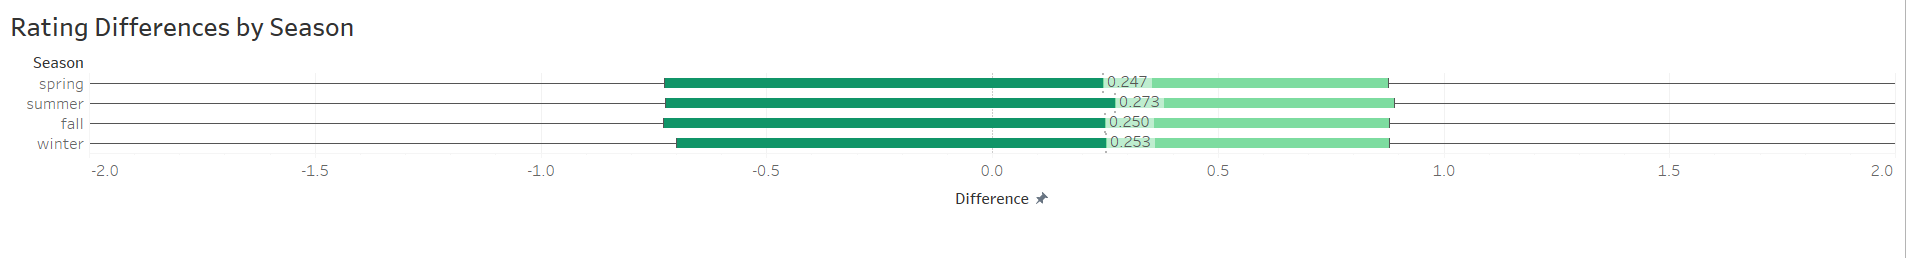

# Section 6 Results/ Interpretations Continued
The following graph answers the second question of our Need. It asks if there is a difference between ratings on a monthly basis. This graph shows that there is a somewhat bigger difference compared to just the seasons. If you look at the summer months you will see that more states that are above their average compared to the winter and spring months. This could determine a distinction that there is a preference for ratings in the summer compared to the other seasons.

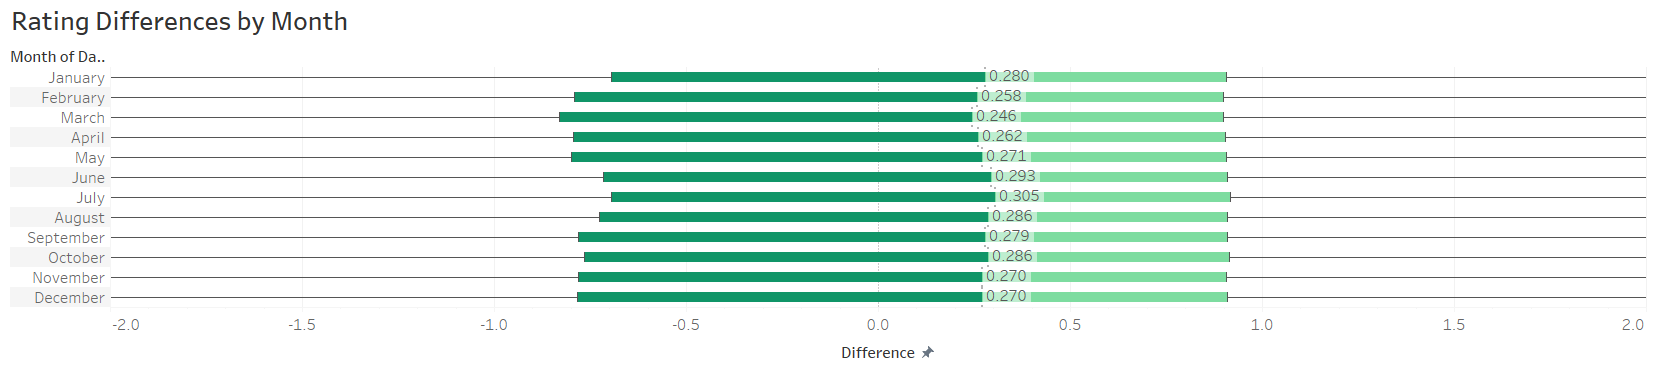

# Section 6 Results/ Interpretation Continued
The following graph shows the difference between ratings on a seasonal and geographical basis. What we find from the graph is that the difference between ratings does vary more throughout the year in each state. For instance, Quebec has a higher difference between its ratings on a yearly basis compared to Arizona most likely because Arizona is constantly hot while Quebec has a more even spread of its seasons. As in Quebec's seasons last about 3 months per year whereas the other states follow some eratic pattern.



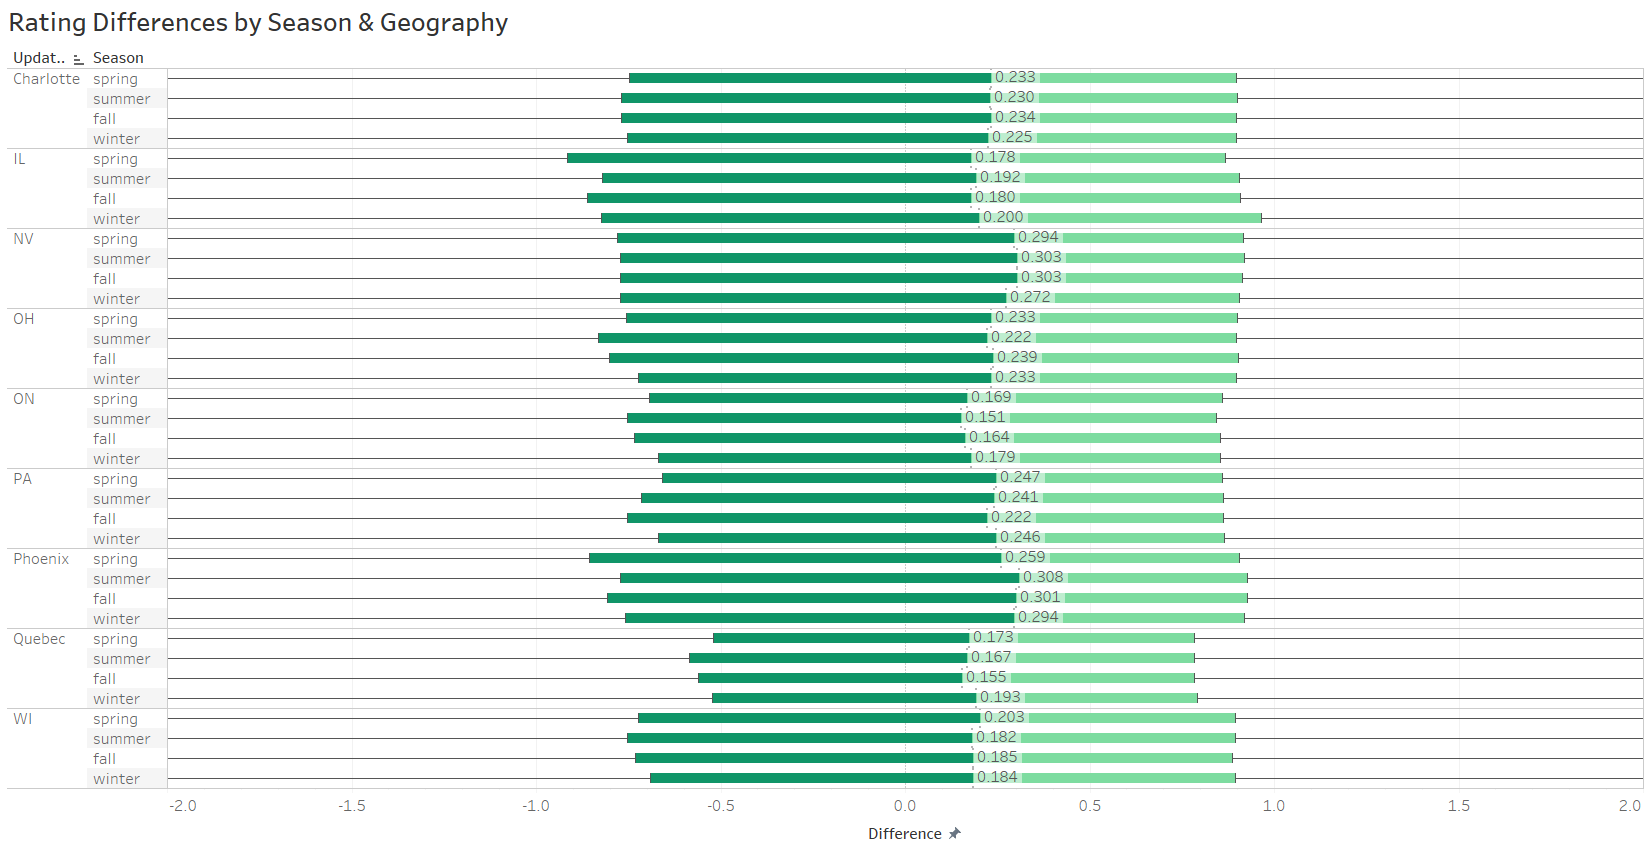

# Section 6 Results/ Interpretation Continued
The following graph shows the differnce between ratings for each category. What this indicates is that people do not have a preference on the time of year. This graph indicates that people prefer shopping just slightly more then the other categories but not by much. This graph shows that regardless of the season users are going to rate a category about the same with very little distinction. 


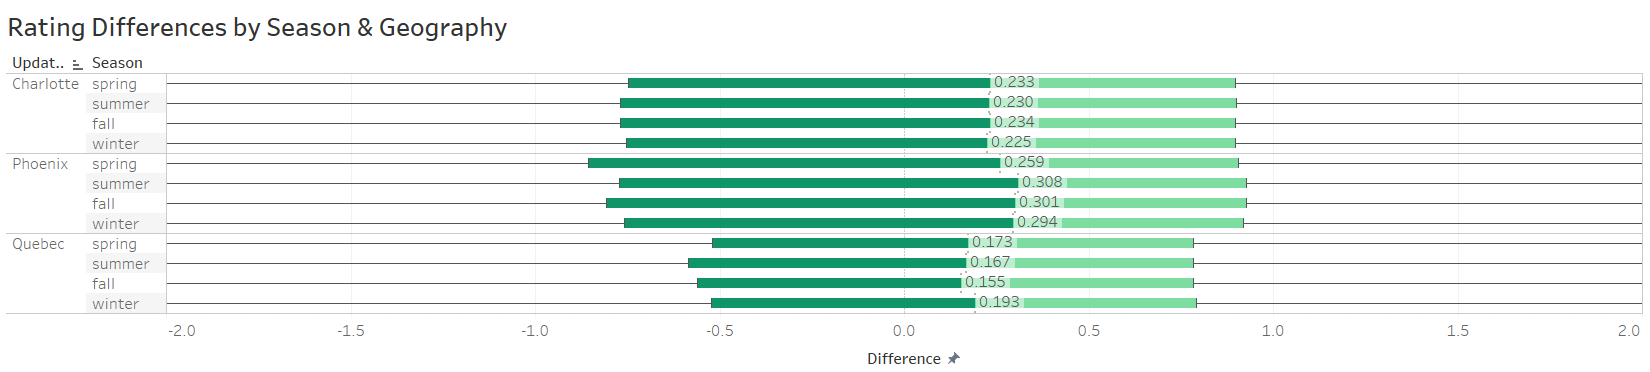

# Section 7 - Limitations
There are 3 limitations to consider when reviewing this data. They are: 
1. If the reviews were genuine, or if they were infleunced by other users, shop owners. Sometimes many stores offer discounts to customer if they give them a positive review, this could affect the genuineness of the review. <br>

2. There could be a considerable delay between the user visiting the business and reviwing it. This can affect :-
    a. quality of the review
    b. accuracy of the review
    c. lenght of the review
    
3. The biggest limitation is the accuracy of the seasons. This data set contains reviews from the last 13 years and in that time there have been wild and unpredictable changes in the weather. For instance, Wisconsin may have been considered in Spring in April last year but 10 years ago it could have been considered in Winter or even Summer. This limitation can be resolved by further specifying our case statement but it would require much more time to investigate the seasonal patterns for each year of each state. For the purposes of this project we averaged our seasons and generalized that the climate data was consistent for each year. 